In [28]:
import torch_geometric as tog
import pandas as pd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

In [29]:

zinc = tog.datasets.ZINC(
    root="/Users/clementbarcaroli/Desktop/Projet GNN/data")

The task is to regress the penalized logP, or octanol-water partition coefficient, is a measure of how hydrophilic or hydrophobic a molecule is (per https://www.biotage.com/blog/what-is-the-role-of-logp-in-sample-prep-methods)

In [30]:
#y is converted because it is originally in double format, which is not well handled by pytorch
train = tog.datasets.ZINC(root="data", split="train")
train.data.y = train.data.y.float() 
val   = tog.datasets.ZINC(root="data", split="val")
val.data.y = val.data.y.float()
test  = tog.datasets.ZINC(root="data", split="test")
test.data.y = test.data.y.float()

/var/folders/td/ygzb10g95l1b1v6fvr94tbv00000gn/T/ipykernel_50114/4155381171.py:3: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  train.data.y = train.data.y.float()
/var/folders/td/ygzb10g95l1b1v6fvr94tbv00000gn/T/ipykernel_50114/4155381171.py:5: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  val.data.y = val.data.y.float()
/var/folders/td/ygzb10g95l1b1v6fvr94tbv00000gn/T/ipy

In [31]:
zinc[12]
#x=[23,1]==> the 12th molecule has 23 atoms, each with a feature vector. Therefore, we have 23 nodes.
#edge_index = [2,50] ==> the bonds between atoms are bidirectional (indicated by 2), so 50 directed edges represent 25 bonds
#edge_attributes = [50] ==> 50 edges 
#y=[1] ==> gives the size of the label logP (in this case 1 bc only one graph taken)
zinc[12].y  #logP value of the 12th molecule = -2,5784

tensor([-2.5784])

In [32]:
test_loader = tog.loader.DataLoader(test, batch_size=32, shuffle=True)
train_loader = tog.loader.DataLoader(train, batch_size=32, shuffle=True)
val_loader = tog.loader.DataLoader(val, batch_size=32, shuffle=True)

In [33]:
#Example of a batch 
#Each batch contains 32 graphs except the last one of size 8

for batch in test_loader:
    print(batch)
    print(batch.num_graphs)

DataBatch(x=[748, 1], edge_index=[2, 1608], edge_attr=[1608], y=[32], batch=[748], ptr=[33])
32
DataBatch(x=[742, 1], edge_index=[2, 1598], edge_attr=[1598], y=[32], batch=[742], ptr=[33])
32
DataBatch(x=[753, 1], edge_index=[2, 1624], edge_attr=[1624], y=[32], batch=[753], ptr=[33])
32
DataBatch(x=[737, 1], edge_index=[2, 1588], edge_attr=[1588], y=[32], batch=[737], ptr=[33])
32
DataBatch(x=[764, 1], edge_index=[2, 1646], edge_attr=[1646], y=[32], batch=[764], ptr=[33])
32
DataBatch(x=[745, 1], edge_index=[2, 1602], edge_attr=[1602], y=[32], batch=[745], ptr=[33])
32
DataBatch(x=[736, 1], edge_index=[2, 1558], edge_attr=[1558], y=[32], batch=[736], ptr=[33])
32
DataBatch(x=[707, 1], edge_index=[2, 1512], edge_attr=[1512], y=[32], batch=[707], ptr=[33])
32
DataBatch(x=[744, 1], edge_index=[2, 1592], edge_attr=[1592], y=[32], batch=[744], ptr=[33])
32
DataBatch(x=[720, 1], edge_index=[2, 1550], edge_attr=[1550], y=[32], batch=[720], ptr=[33])
32
DataBatch(x=[734, 1], edge_index=[2, 157

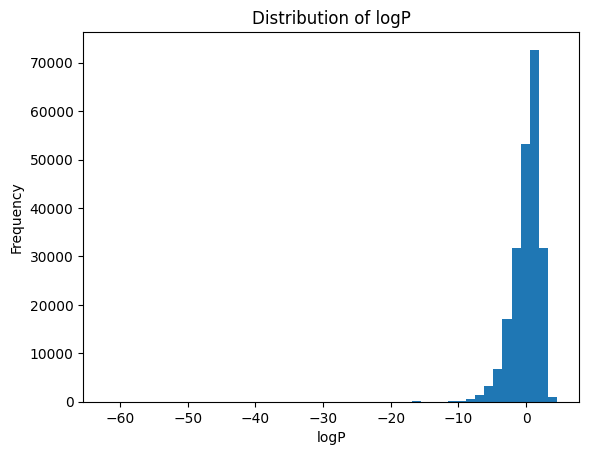

In [34]:
#To get an idea of the scale of logP, we plot its distribution in the training set.

logP_values = []
for data in train:
    logP_values.append(data.y.item())
logP_series = pd.Series(logP_values)
logP_series.plot(kind='hist', bins=50, title='Distribution of logP', xlabel='logP', ylabel='Frequency')

plt.show()

#Values centered around 0, with a left tail rather long for a log transform. 

In [45]:
y_train = train.data.y.float()

y_min = y_train.min().item()
y_max = y_train.max().item()
y_mean = y_train.mean().item()
y_std = y_train.std().item()

print(f"logP min (train): {y_min:.3f}")
print(f"logP max (train): {y_max:.3f}")
print(f"logP mean (train): {y_mean:.3f}")
print(f"logP std (train): {y_std:.3f}")

logP min (train): -62.138
logP max (train): 4.519
logP mean (train): -0.000
logP std (train): 2.049


/var/folders/td/ygzb10g95l1b1v6fvr94tbv00000gn/T/ipykernel_50114/3397514708.py:1: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  y_train = train.data.y.float()


In [ ]:
#Forward needs a sampling (done automatically by torch), convolutions and at least one pooling before the final activation.

class GCN(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
#2 GIN convolutions, ReLU activation of each convolution
        self.conv1 = tog.nn.GINConv(torch.nn.Sequential(torch.nn.Linear(in_channels, 64),torch.nn.ReLU(),torch.nn.Linear(64, 64),))
        self.conv2 = tog.nn.GINConv(torch.nn.Sequential(torch.nn.Linear(64, 64),torch.nn.ReLU(),torch.nn.Linear(64, 64),))
        self.pooling = tog.nn.SAGPooling(64, ratio=0.5) #Not used, the model did not learn with it

#Fully connected layer to perform regression on the graph-level representation
        self.lin = torch.nn.Linear(64, 1)

    def forward(self, data):
        x, edge_index, batch = data.x.float(), data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        #x, edge_index, batch = self.pooling(x, edge_index, batch)
        x = self.conv2(x, edge_index)
        #x, edge_index, batch = self.pooling(x, edge_index, batch)
        x = tog.nn.global_mean_pool(x, batch)

        return self.lin(x) #activation 
    

GIN = Graph Isomorphism Network from https://arxiv.org/abs/1810.00826. It is a spatial convolution, conceived as an upgrade to the approach seen in Duvenaud et al (2015).
global_mean_pool = pooling by taking the mean. It is a direct pooling, because there are not enough nodes per graph for hierarchical to be needed.

In [ ]:
#Training phase is quite long, 100 epochs used just to showcase convergence 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCN(train.num_node_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.L1Loss() #We use the MAE because y is continuous

model.train()

for epoch in range(100):
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        batch.batch = batch.batch.long()

        optimizer.zero_grad()
        out = model(batch).squeeze(-1)   #.squeeze(-1) to remove the last dimension of size 1, which caused problems to compute the loss
        loss = loss_fn(out, batch.y.float())
        loss.backward() #Backpropagation
        optimizer.step()

        total_loss += loss.item() * batch.num_graphs

    print(f"Epoch {epoch:03d} | Loss {total_loss / len(train):.4f}") #To see the progress at each epoch in terms of MAE



Epoch 000 | Loss 1.1082
Epoch 001 | Loss 0.9802
Epoch 002 | Loss 0.9146
Epoch 003 | Loss 0.8737
Epoch 004 | Loss 0.8529
Epoch 005 | Loss 0.8340
Epoch 006 | Loss 0.8217
Epoch 007 | Loss 0.8144
Epoch 008 | Loss 0.8075
Epoch 009 | Loss 0.7998
Epoch 010 | Loss 0.7957
Epoch 011 | Loss 0.7903
Epoch 012 | Loss 0.7848
Epoch 013 | Loss 0.7816
Epoch 014 | Loss 0.7759
Epoch 015 | Loss 0.7700
Epoch 016 | Loss 0.7639
Epoch 017 | Loss 0.7604
Epoch 018 | Loss 0.7562
Epoch 019 | Loss 0.7534
Epoch 020 | Loss 0.7491
Epoch 021 | Loss 0.7478
Epoch 022 | Loss 0.7455
Epoch 023 | Loss 0.7442
Epoch 024 | Loss 0.7399
Epoch 025 | Loss 0.7379
Epoch 026 | Loss 0.7348
Epoch 027 | Loss 0.7351
Epoch 028 | Loss 0.7323
Epoch 029 | Loss 0.7309
Epoch 030 | Loss 0.7291
Epoch 031 | Loss 0.7269
Epoch 032 | Loss 0.7250
Epoch 033 | Loss 0.7245
Epoch 034 | Loss 0.7238
Epoch 035 | Loss 0.7213
Epoch 036 | Loss 0.7203
Epoch 037 | Loss 0.7204
Epoch 038 | Loss 0.7182
Epoch 039 | Loss 0.7160
Epoch 040 | Loss 0.7148
Epoch 041 | Loss

In [ ]:
#Now that the model is trained, we can evaluate it on the test set

def evaluate(model, loader, dataset, device):
    model.eval()
    total_error = 0.0

    for batch in loader:
        batch = batch.to(device)
        out = model(batch).squeeze(-1)     #To remove the last dimension of size 1 which caused problems
        error = torch.abs(out - batch.y.float()) #Absolute error
        total_error += error.sum().item()

    return total_error / len(dataset) #Same thing as before with the training phase

test_mse = evaluate(model, test_loader, test, device)
print(f"Test MAE: {test_mse:.4f}")

#From what we saw of the logP distribution, the MAE being around 0.66 is a bit high but acceptable for a showcase


Test MAE: 0.6655
